In [1]:
### Functionalize code from experimentation notebook

### Date: Feb 7, 2023
### Author: Jonathan Chan

### Notes: 
### TEAM TWITTER HANDLES FROM: https://ourworldindata.org/team

In [2]:
#General
import re
import json
import numpy as np
import pandas as pd

#for data collection - webscraping
import requests
from bs4 import BeautifulSoup
import re

#handling plots
import matplotlib.pyplot as plt

#for network creation
import networkx as nx

#for data collection - tweepy API 
import tweepy
import twitter_credentials #Twitter credentials stored in a file: twitter_credentials.py

consumer_key = twitter_credentials.CONSUMER_KEY
consumer_secret = twitter_credentials.CONSUMER_SECRET 
access_token = twitter_credentials.ACCESS_TOKEN
access_token_secret = twitter_credentials.ACCESS_SECRET

Goal: to scrape x number of tweets from each OWID team member and create a) a network map, b) a bigrams 

The following code will perform the following steps with one or more functions for each

### Steps:

1. Collect OWID team Twitter handles from the website - 
    output file: owid_team_info.csv (dataframe with columns: name, title, team, twitter_username, other_links
    
2. Iterate through Twitter handles, collect 250 tweets
    output: store as raw_tweets_DATE.json
    assume twitter developer credentials are set up already - imported as twitter_credentials.py
    
3. From raw_tweets_DATE.csv,
    sub function: from json, get list of tuples in (user, interaction) format
    sub function: from list of tuples, get network graph

In [9]:
## STEP 1:

def get_team_info(in_url="https://ourworldindata.org/team"):
    """
    Returns dataframe containing the info for each OWID team member. 
        columns:
            name: name of team member (str)
            title: job position name of team member (str)
            twitter_username: twitter username (str - no @ symbol) OR None 
            other_links: other links found at bottom of each member's section (list of str)
            
    input: 
        in_url: string containing the url for the OWID team page
    Notes:
        - Assume format of in_url matches webpage format of "https://ourworldindata.org/team"
        as of Feb 6, 2023.
        - Unless otherwise indicated, String values are scraped
        as they appear on the OWID team site - includes honorifics and capitalization 
    """
    response=requests.get(in_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    team_info= []
    
    #iterate through div element that contain info for each teammate (class name: wp-block-media-text__content)
    for tm_div in soup.find_all(class_="wp-block-media-text__content"):

        tm_name = tm_div.find("h4").text #name in h4 tag
        tm_title = tm_div.find("h5").text #title in h5 tag
        tm_twitter=None #variable to store twitter handle as string if it exists
        tm_other = [] #list to write non-twitter links to
        
        for p in tm_div.find_all("p"):
            links_list = p.find_all("a", href=True) 
            for link in links_list:
                if 'twitter' in link['href']:
                    tm_twitter = link['href'].split("/")[-1] #split by '/' and take last item to get twitter handle
                    tm_twitter = tm_twitter.replace("@", "") #remove @ symbol - easier to pass to Tweepy module
                else:
                    tm_other.append(link['href']) #add non-twitter links as 'other_links' column

        tm_dict = {
            "name": tm_name,
            "title": tm_title,
            "twitter_username": tm_twitter,
            "other_links": tm_other
        }
        team_info.append(tm_dict) 
    
    #MANUAL CHECKS - spot check 
    assert len(team_info) == 26
    assert "Max Roser" in team_info[0]['name']
    assert "Jason Crawford" in team_info[-1]['name']
    
    return pd.DataFrame(team_info)





In [10]:
url = "https://ourworldindata.org/team"
# team_df = get_team_info(url)
team_df = get_team_info()
team_df.head()

# team_df.to_csv("")

,name,title,twitter_username,other_links
0,Dr. Max Roser,Founder and Director,MaxCRoser,[https://ourworldindata.org/history-of-our-wor...
1,Dr. Esteban Ortiz-Ospina,Head of Strategy and Operations,eortizospina,"[https://global-change-data-lab.org/, mailto:e..."
2,Dr. Hannah Ritchie,Deputy Editor and Science Outreach Lead,_HannahRitchie,[mailto:hannah@ourworldindata.org]
3,Edouard Mathieu,Head of Data and Research,redouad,[]
4,Dr. Lars Yencken,Head of Engineering,larsyencken,[mailto:lars@ourworldindata.org]


In [11]:
## STEP 2: connect to API, intake team_df, 
#return json containing all tweets, as well as list of no twitter data available 

#SUBFUNCTION - input twtter handle, number of tweets
#FUNCTION - creates the JSON 

def get_user_tweets(curr_user="OurWorldInData", num_tweets=100):
    """Returns a list of raw tweet JSON items based on a username
    
    
    Note: 
        REFACTOR: handle queries of tweets more than tweepy limit for a specific
        Assume consumer_key, consumer secret are defined before calling function
        
        please consult developer docs to ensure that your Twitter Developer account
        can access the number of tweets you are interested in per month
        https://developer.twitter.com/en/support/twitter-api/developer-account
    """
    #authenticate twitter credentials
    auth = tweepy.OAuth2AppHandler(
    consumer_key, consumer_secret
    )
    #add parser to avoid error of non-serializable data: 
    #https://github.com/tweepy/tweepy/issues/1102
    api = tweepy.API(auth, 
                     parser=tweepy.parsers.JSONParser() 
        )
    
    #collect num_tweets
    all_tweets = []
    tweets_extended = api.user_timeline(
                                        screen_name=curr_user, #replaced id=curr_user to remove warning in jupyter notebook
                                        tweet_mode='extended', 
                                        count=num_tweets)
    all_tweets = all_tweets + tweets_extended
    print(len(all_tweets))
#     print("COLLECTED: {} TWEETS FROM {}".format(str(num_tweets), username))
    return all_tweets

In [36]:
test_tweets=get_user_tweets('MaxCRoser', 15)

15


In [38]:
test_tweets[-3]['entities']['hashtags']

[]

In [54]:
def get_tweets_df(team_list, tweets_per_tm=5):
    """Return a dataframe where each row is a tweet from usernames in team_list. Number of tweets collected is defined
    as tweet_per_tm (default=100). Final dataframe includes tweet date, id, full text, rt/fav count, hashtag list, and list of 
    accounts that the tweet interacted with (mentions, replies, retweets) stored as tuples (tweet poster, interacted account)
    
    input:
        team_list: list of twitter handles of team members to collect tweets from(list of str)
        tweets_per_tm: number of tweets to collect per team member (int)
    
    Notes:
        -Interactions are stored in raw tweet data collected from get_user_tweets() - in tweet['entities']['user_mentions']
        -Retweet and favourite counts only consider the tweet from the team member - does not include retweets/likes on the original tweet
        Refactor: nested for loops
    """
    tweet_list = []
    all_ints = []
    print("TEAM_LIST",team_list)
    for team_member in team_list:
        print("TM TO SCRAPE:", team_member)
        tm_tweets = get_user_tweets(team_member, tweets_per_tm)
        for tweet in tm_tweets:
            tweet_ints=[]
            tweet_date = tweet['created_at']
            tweet_id = tweet['id_str'] #id of ACTUAL TWEET
            tweet_text= tweet['full_text']
            tweet_rts= tweet['retweet_count']
            tweet_favs= tweet['favorite_count']
            tweet_hts = tweet['entities']['hashtags']
            
            user_id = tweet['user']['id_str']
            user_name = tweet['user']['screen_name']

            interacted_names = [x['screen_name']for x in tweet['entities']['user_mentions']]
            interacted_ids = [x['id_str'] for x in tweet['entities']['user_mentions']]
            
            for interacted in interacted_names:
                int_tuple = tuple((user_name, interacted))
                tweet_ints.append(int_tuple)
                all_ints.append(int_tuple)

#             print("TEAM MEMBER:", user_name)
#             print("TWEET TEXT: ", tweet_text)
#             print("TWEET INTERACTIONS:", interacted_names)
#             print("TOTAL INTERACTIONS: ",interactions)
            tweet_dict = {
                "tweet_date": tweet_date,
                "tweet_id": tweet_id,
                "full_text": tweet_text,
                "retweet_count": tweet_rts,
                "fav_count": tweet_favs,
                "hashtags": tweet_hts,
                "user_id": user_id, 
                "user_name": user_name,
                "interacted_tuples": tweet_ints
            }
            tweet_list.append(tweet_dict)
#             print(tweet_dict)
#             print("----")
#         print("*****")
        
    return pd.DataFrame(tweet_list)

In [56]:
team_list_test=team_df['twitter_username'][:4]
print(team_list_test)
get_tweets_df(team_list_test,10).tail()

0         MaxCRoser
1      eortizospina
2    _HannahRitchie
3           redouad
Name: twitter_username, dtype: object
TEAM_LIST 0         MaxCRoser
1      eortizospina
2    _HannahRitchie
3           redouad
Name: twitter_username, dtype: object
TM TO SCRAPE: MaxCRoser
10
{'tweet_date': 'Wed Feb 08 08:49:31 +0000 2023', 'tweet_id': '1623242610276986881', 'full_text': 'This is one of the ways we visualize that data. \n\nNot with an emphasis on the average of it all, but in a way that lets you see the differences between forecasts.\n\n[from our article on AI timelines https://t.co/RusReab8dm] https://t.co/rATao7ia2z', 'retweet_count': 8, 'fav_count': 50, 'hashtags': [], 'user_id': '610659001', 'user_name': 'MaxCRoser', 'interacted_tuples': []}
----
{'tweet_date': 'Wed Feb 08 08:46:30 +0000 2023', 'tweet_id': '1623241850021609475', 'full_text': "This is the chart on AI timelines that I see in most talks on the topic.\n\nI don't think this it is a good way to represent this data.\n\nA visu

10
{'tweet_date': 'Wed Feb 08 15:10:49 +0000 2023', 'tweet_id': '1623338566725115910', 'full_text': "RT @OurWorldInData: 🚨 We're hiring a Human Resources Manager! 🚨\n\nThe HR Manager will drive the hiring, development, engagement, and retenti…", 'retweet_count': 12, 'fav_count': 0, 'hashtags': [], 'user_id': '2666969059', 'user_name': '_HannahRitchie', 'interacted_tuples': [('_HannahRitchie', 'OurWorldInData')]}
----
{'tweet_date': 'Wed Feb 08 08:15:21 +0000 2023', 'tweet_id': '1623234011144364034', 'full_text': "@geographile Yes, sorry – by 'second largest', I meant 'second largest in Turkey'", 'retweet_count': 0, 'fav_count': 2, 'hashtags': [], 'user_id': '2666969059', 'user_name': '_HannahRitchie', 'interacted_tuples': [('_HannahRitchie', 'geographile')]}
----
{'tweet_date': 'Wed Feb 08 05:56:07 +0000 2023', 'tweet_id': '1623198972394307585', 'full_text': 'https://t.co/nXrD7fnegl', 'retweet_count': 2, 'fav_count': 10, 'hashtags': [], 'user_id': '2666969059', 'user_name': '_HannahRit

,tweet_date,tweet_id,full_text,retweet_count,fav_count,hashtags,user_id,user_name,interacted_tuples
35,Mon Feb 06 13:07:58 +0000 2023,1622582874691043329,RT @EOrtizOspina: A chart showing the history ...,28,0,[],41676231,redouad,"[(redouad, EOrtizOspina)]"
36,Sun Feb 05 14:00:12 +0000 2023,1622233633850368002,"RT @_HannahRitchie: Since 2012, @timesofindia ...",203,0,[],41676231,redouad,"[(redouad, _HannahRitchie), (redouad, timesofi..."
37,Sat Feb 04 14:18:22 +0000 2023,1621875816354250761,RT @UniofOxford: 'Almost ten million people di...,54,0,[],41676231,redouad,"[(redouad, UniofOxford), (redouad, OurWorldInD..."
38,Sat Feb 04 14:00:12 +0000 2023,1621871246811041792,RT @EOrtizOspina: The covid pandemic pushed mi...,53,0,[],41676231,redouad,"[(redouad, EOrtizOspina)]"
39,Fri Feb 03 14:00:17 +0000 2023,1621508880546295810,RT @_HannahRitchie: 99% of the Indian populati...,1766,0,[],41676231,redouad,"[(redouad, _HannahRitchie)]"


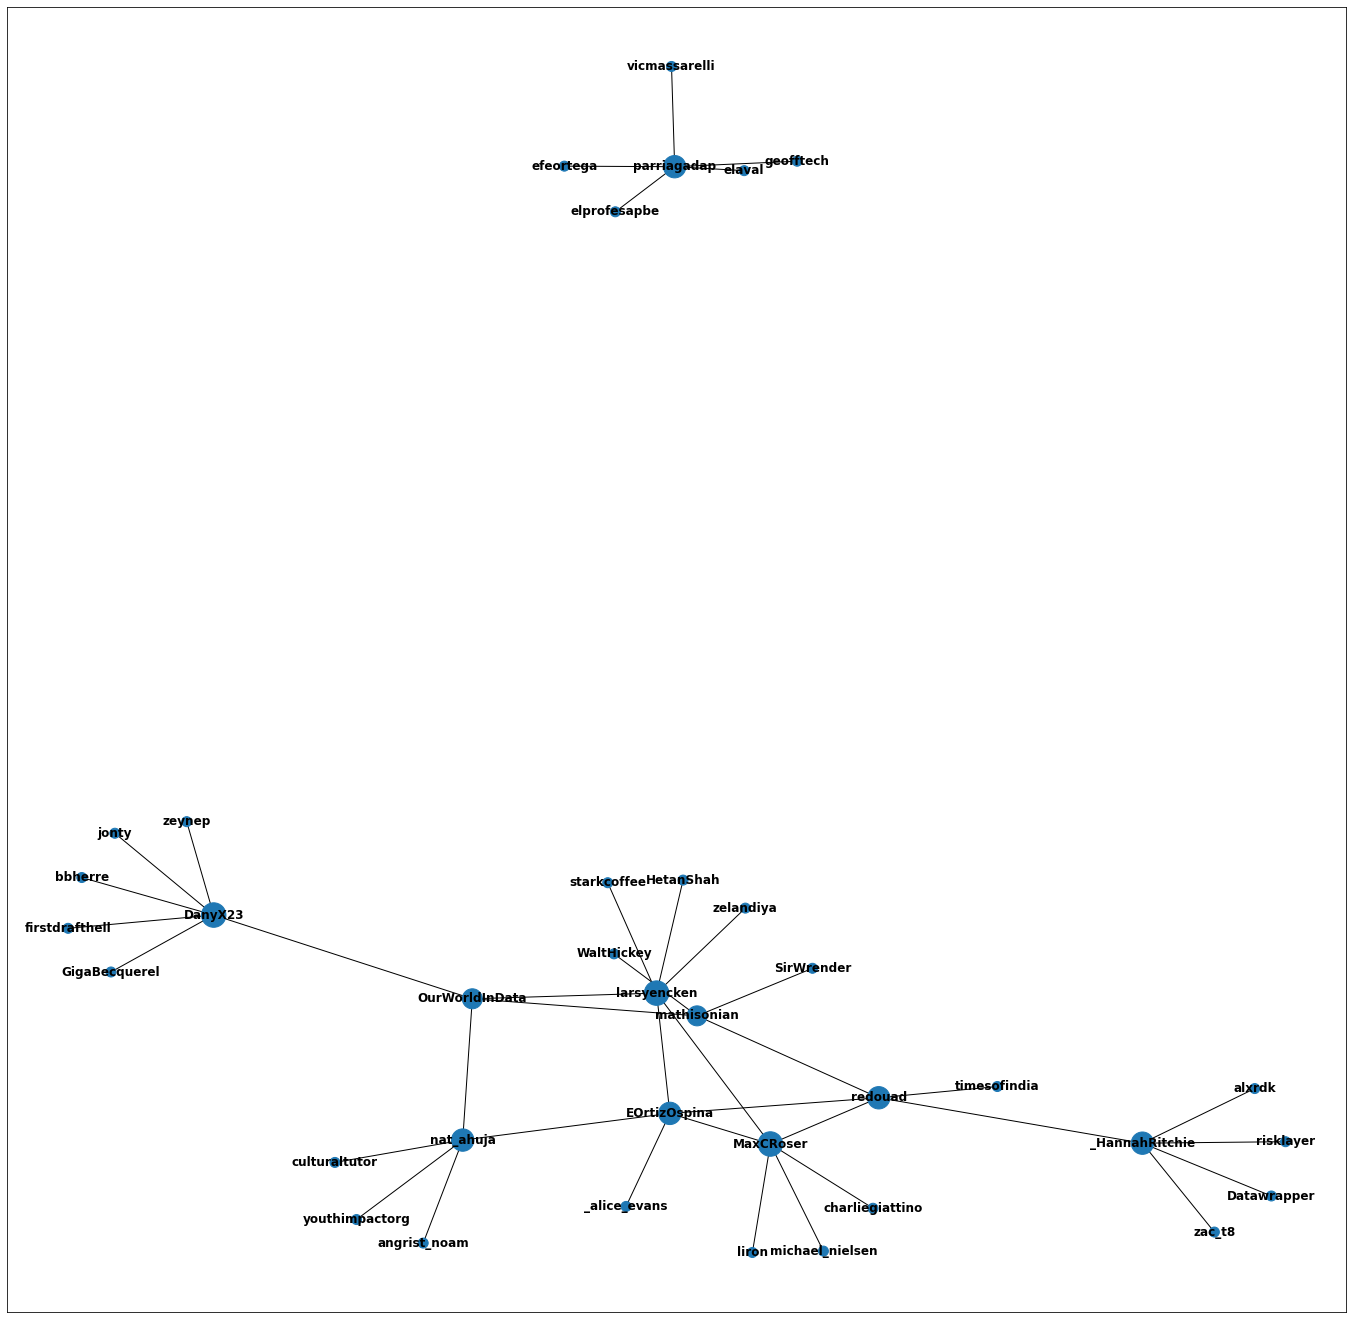

In [159]:
#get the degree for each node, then get the values
deg = nx.degree(graph)
degree_values = [v for k, v in deg]
node_size = [v * 100 for v in degree_values] #multiply by 100 to show properly 
position = nx.fruchterman_reingold_layout(graph)

plt.figure(3,figsize=(24,24))
nx.draw_networkx(graph, pos=position, 
                 with_labels=True, node_size=node_size,
        font_weight='bold')

In [135]:
#OBS
# def collect_team_tweets(out_filename='raw_tweets.json', tweets_per_tm=5):
#     """
#     Writes a file 'raw_tweets.json' to working directory using the function
#     get_user_tweets()
    
#     input:
#         out_filename: file name to write json to in working directory (end in '.json')
#         tweets_per_tm: number of tweets to collect per team member(int)
    
#     """
#     twitterless_tm = []
#     twittered_tm = []
#     twittered_data = {}

#     for i, row in team_df.iterrows():
#         user_name = row['twitter_username']
#         if user_name:
#             curr_tweets = get_user_tweets(user_name, tweets_per_tm)
#             twittered_data[username]= curr_tweets
#         else:
#             twitterless_tm.append(row['name'])
#     assert(len(twittered_data) + len(twitterless_tm) == 26)
    
#     with open(out_filename, "w") as f:
#         json.dump(twittered_data, f)
      
#     print("TWITTER DATA FINAL LEN: ", len(twittered_data))    
#     print("NO TWITTER AVAILABLE: ", ", ".join(twitterless_tm))
#     print("OUTPUT FILE: ", out_filename)
    


In [148]:
# collect_team_tweets("raw_tweets_25.json", 50)



In [57]:
# # OBS

# tweets_per_tm=5
# graph = nx.Graph()
# for team_member in team_df['twitter_username']:
#     print(team_member)
    
#     if team_member:
#         print("YESS")
#         tm_tweets = get_user_tweets(team_member, tweets_per_tm)
#         for tweet in tm_tweets:
#             tweet_date = tweet['created_at']
#             tweet_id = tweet['id_str'] #id of ACTUAL TWEET
#             tweet_text= tweet['full_text']
#             user_id = tweet['user']['id_str']
#             user_name = tweet['user']['screen_name']

#             interacted_names = [x['screen_name']for x in tweet['entities']['user_mentions']]
#             interacted_ids = [x['id_str'] for x in tweet['entities']['user_mentions']]
# #             print("1 TWEET - TEAM MEMBER, USER NAME, INTERACTED NAMES: ", team_member, user_name, interacted_names )
#             ### user_name == team_member
#             for interacted in interacted_names:
#                 graph.add_edge(user_name, interacted, tweet_id = tweet_id)   
#     else:
#         print("NOOOO")

In [149]:
# def get_tm_data(in_json='raw_tweets.json',tm_subgroup=['MaxCRoser']):
#     """Return the nx.graph() containing the interactions of users listed in tm_subgroup"""
#     in_

# def create_nx_graph():

In [150]:
# data['MaxCRoser'][1]

In [151]:
# in_json='raw_tweets.json'
# with open(in_json) as json_file:
#     data=json.load(json_file)
# team_filtered = data.keys()
# # team_filtered = ["MaxCRoser"]
# team_filtered

# for username in team_filtered:
#     tweet_list = data[username]
#     print(tweet_list[0])

In [152]:

# filtered_tweets = []

# graph=nx.Graph()
# #First loop - extract relevant items from raw json - only for users in filtered 
# for username in team_filtered:
#     tweet_list = data[username]
#     print("CURRENT TWITTER HANDLE: ", username)
#     for tweet in tweets_list:
# #         print(tweet.keys())
#         tweet_date = tweet['created_at']
#         tweet_id = tweet['id_str'] #id of ACTUAL TWEET
#         tweet_text= tweet['full_text']
#         user_id = tweet['user']['id_str']
#         user_name = tweet['user']['screen_name']
        
#         interacted_names = [x['screen_name']for x in tweet['entities']['user_mentions']]
#         interacted_ids = [x['id_str'] for x in tweet['entities']['user_mentions']]
        
#         for interacted in interacted_names:
#             graph.add_edge(username, interacted_name, tweet_id = tweet_id)
        
#         tweet_dict = {
#             "user_id": user_id,
#             "user_name": user_name,
#             "tweet_id": tweet_id,
#             "tweet_date": tweet_date,
#             "tweet_text": tweet_text,
#             "interacted_ids": interacted_ids,
#             "interacted_names": interacted_names    
#         }
#         filtered_tweets.append(tweet_dict)
        
# print(filtered_tweets[0])


In [160]:
# graph = nx.Graph()
# #PART 2: for all tweets in filtered_tweets, add an interaction to the nx.graph()
# for tweet in filtered_tweets:
#     print(tweet.keys())
#     user_name = tweet['user_name']
#     tweet_id = tweet['tweet_id']
#     interacted_ids = tweet['interacted_ids']
#     if len(interacted_ids) == 0:
#         print("     NO INTERACTIONS")
#     else:
#         for interacted_name in tweet['interacted_names']:
#             print(tuple((user_name, interacted_name)))
#     print("---")
    
    

    #CHECK: user_name for some tweets is the user that should be in the interacted_list